# Thermal Occupations Notebook 
#### -- Created by Vincent Martinetto 
#### -- Updated and correct by Anthony Osborne 

## Imports

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from scipy.integrate import simps
import matplotlib.animation as animation
from IPython.display import HTML
#import iDEA
import math
from matplotlib import cm
import scipy
from decimal import Decimal

# Non-interacting

## Set-up

### Definition of harmonic oscillator external potential and fermi occupation function
##### These are fine 3rd, June 2024 -- AO

In [4]:
# Fermi Occupation function
def occs(Eis,mu,tau):
    '''
    INPUT:
        tau: Scalar
            the tau value to find the temprature dependent mu for
        mus: scalar
            a guess at a value below the chemical potential for tau
        Eis: Scalar
            Some kind of energy -- AO
    OUTPUT
        F_occs: Scalar
            The Fermi Occupation for mu, tau, Eis
    '''
    F_occs = 1/(1+np.exp((Eis-mu)/tau))
    return F_occs

In [5]:
#Harmonic oscillator external potential
def v_harm(x):
    return .5*x**2

### Secant Method for root finding

##### Seems fine 3rd, June 2024 -- AO

In [6]:
def secant(x0,x1,fx0,fx1):
    '''
    the update process for the secant method
    '''
    return (x0*fx1-fx0*x1)/(fx1-fx0)

def secant_method(x0,x1,func,criterion=1e-6,max_iter=100):
    '''
    Description: Based on the secant method page on wikipedia
    takes the first two guesses at the correct root and a defined
    function then run the secant method to find the root.
    INPUT:
        x0: Scalar
            First guess at root value
        x1: scalar
            Second guess at root value
        func: Scalar
            Function to find root of
    OUTPUT
        x1: Scalar
            Root value
        fx1: Scalar
            function evaluated at root value            
    '''
    
    i = 0
    
    fx0 = func(x0)
    fx1 = func(x1)
    conv = abs(min([fx0,fx1]))
    
    while conv > criterion:
        xt = secant(x0,x1,fx0,fx1)
        
        fx0 = fx1
        x0 = x1
        x1 = xt
        fx1 = func(x1)
        
        conv = abs(fx1)
        
        if i > max_iter:
            break
        i += 1
        
    return x1,fx1

### secant test

-1.7080391071060965e-07
-1.7080391071060798e-07


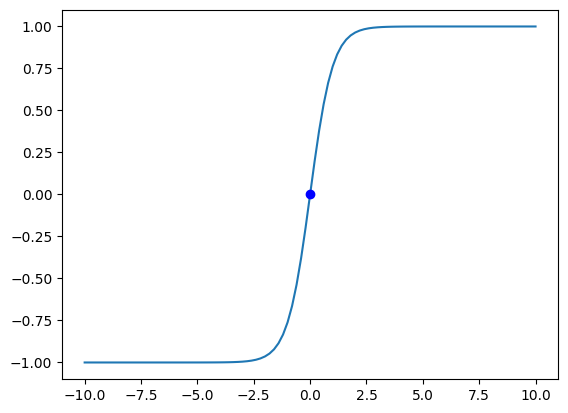

In [7]:
x0,fx0 = secant_method(-2.5,3,np.tanh)
print(x0)
print(fx0)
x = np.linspace(-10,10,101)
plt.plot(x,np.tanh(x))
plt.plot(x0,fx0,'bo')
plt.show()

### Calculate harmonic oscillator or particle in a box

##### Looks fine 3rd, June 2024 -- AO
##### These are used when showing the plot of particle number over $\mu$ is sigmoidal

In [11]:
Nx = 401
x = np.linspace(-5,5,Nx)
v_ext = v_harm(x)
nk = 100
#v_ext = np.zeros(Nx)

dx = x[1]-x[0]
diag = (np.ones(Nx)/dx**2)
#print(diag)
diags = np.array([(v_ext+diag),(diag/-2),(diag/-2)])

H = spa.dia_matrix((diags,[0,-1,1]),shape=(Nx,Nx))
vals, vecs = eigsh(H,which='SA',k=nk)

vec_sum = np.trapz(vecs[:,0]**2,x)
norm = np.sqrt(1/vec_sum)
vecs = vecs*norm
#print(vals)
#print(vecs)

## Show that the plot of particle number over $\mu$ is sigmoidal for a fixed $\tau$

The sigmoid can be shifted such that the single root of the sigmoid is the number of particles. Then we can use a root finding method to mind the proper chemical potnetial, mu, at temprature, tau, such that the number of particles in the system is the same.

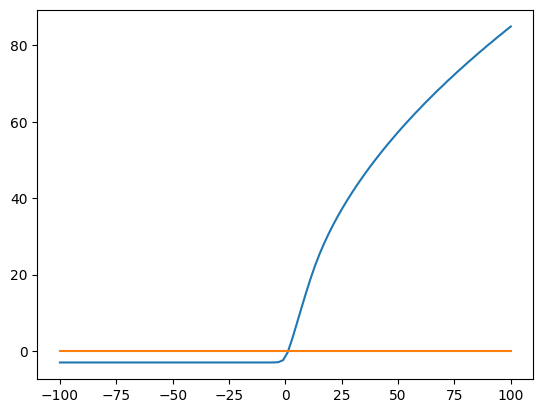

In [13]:
tau = 1
mus = np.linspace(-100,100,100)
Nes = np.empty(len(mus))
for i,mu in enumerate(mus):
    fs = occs(vals,mu,tau)
    dens = np.zeros(len(x))
    for j,f in enumerate(fs):
        dens += f*2*vecs[:,j]**2
    Nes[i] = np.trapz(dens,x)
#print(Nes-3)
plt.plot(mus,Nes-3)
plt.plot(mus,np.zeros(len(mus)))
plt.show()

## Define the function to calculate particle number for a a given $\mu$ and $\tau$ for a set of eigenvectors and values

The next function shifts the particle number function so the root of the function is at the number of paritcles that is wanted

In [9]:
def dens_function(fs,vecs,x):
    '''
    Description: Not even used
    INPUT:
        fs: ndarray
            
        vecs: ndarray
            
        x: ndarray
            
    OUTPUT
        Dens: ndarray
            The density for the system
    '''
    dens = np.zeros(len(x))
    for i,f in enumerate(fs):
        dens+=2*f*vecs[:,i]**2
    return dens

def particle_number_function(mu,tau,vals,vecs,x):
    '''
    Description: Determine the Unshifted particle number
    INPUT:
        mu: Scalar (float)
            chemical potential
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
    OUTPUT
        Ne: Scalar (float)
            The unshifted particle number
    '''
    fs = occs(vals,mu,tau)
    dens = np.zeros(len(x))
    for i,f in enumerate(fs):
        dens += 2*f*vecs[:,j]**2
    Ne = np.trapz(dens,x)
    return Ne

def particle_number_shifter(tau,vals,vecs,x,target_Ne): 
    
    '''
    Old title: particle_number_function_function

    Description: Determines the Shifted particle number
    INPUT:
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
        target_Ne: Scalar (int)
            The desired particle number
    OUTPUT
        particle_number_Shift: Scalar (float)
            The Shifted particle number
    '''

    def particle_number_Shift(mu):
        
        fs = occs(vals,mu,tau)
        dens = np.zeros(len(x))
        for i,f in enumerate(fs):
            dens += 2*f*vecs[:,j]**2
        Ne = np.trapz(dens,x)
        
        return Ne - target_Ne
    
    return particle_number_Shift

In [10]:
taus = np.linspace(1,100,1001)
dtau = taus[1]-taus[0]
mus = np.empty(len(taus))
Nes = np.empty(len(taus))
mu0s = np.empty(len(taus))
mu1s= np.empty(len(taus))
mu_upper = np.empty(len(taus))

mu0 = 1
mu1 = 5

for i,tau in enumerate(taus):
    mu_upper[i] = mu1
    
    func = particle_number_shifter(tau,vals,vecs,x,3)
    mu1,fx0 = secant_method(mu0,mu1,func,criterion=1e-10)
    
    mu0s[i] = mu0
    mu1s[i] = mu1
    
    mus[i] = mu1
    Nes[i] = particle_number_function(mu1,tau,vals,vecs,x)
    
    mu0 = mu1-(dtau+(.1*dtau*i))

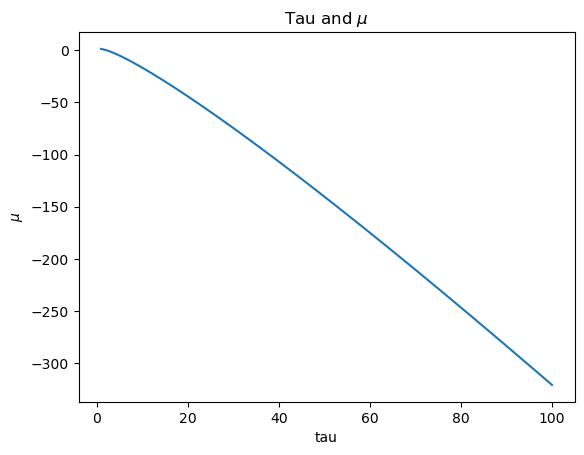

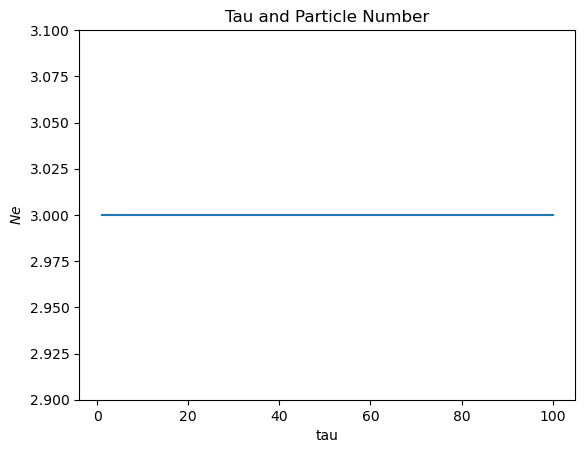

In [11]:
plt.plot(taus,mus)
plt.title("Tau and $\\mu$")
plt.xlabel('tau')
plt.ylabel('$\\mu$')
plt.show()

plt.plot(taus,Nes)
plt.ylim(2.9,3.1)
plt.title("Tau and Particle Number")
plt.xlabel('tau')
plt.ylabel('$Ne$')
plt.show()

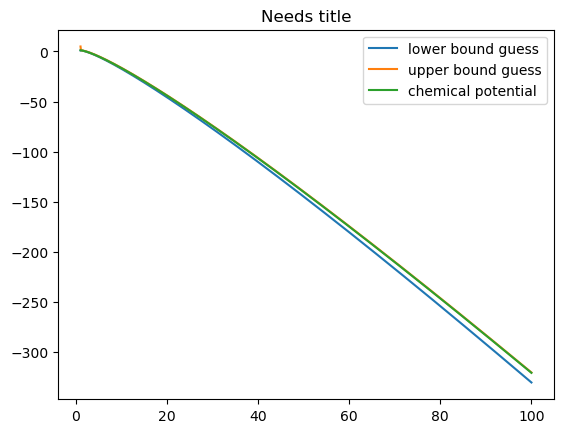

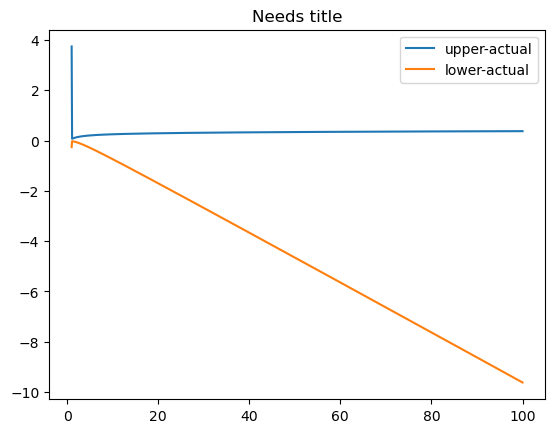

In [12]:
plt.plot(taus,mu0s,label='lower bound guess')
plt.plot(taus,mu_upper,label='upper bound guess')
plt.plot(taus,mu1s,label='chemical potential')
plt.title("Needs title")
plt.legend()
plt.show()
plt.plot(taus,mu_upper-mu1s,label='upper-actual')
plt.plot(taus,mu0s-mu1s,label='lower-actual')
plt.title("Needs title")
plt.legend()
plt.show()

## Implement a search over a range of $\tau$ that returns $\mu$ for each value of $\tau$ to conserve a number of particles

### need a search function for single particle functions using fermi statitics

In [13]:
def tau_search(taus,mu0,mu1,vals,vecs,x,Ne,criterion=1e-10):
    '''
    INPUT:
        taus: vector, len=n
            the tau value to find the temperature dependent mu for
        mu0: scalar
            a guess at a value below the chemical potential for taus[0]
        mu1: scalar
            a guess for a value above the chemical potential for taus[0]
        vals: vector, len=k
            The eigenvalues of the eigenvectors that the mus should be computed for
        vecs: matrix, size=(Nx,k)
            The eigenvectors of the system that mu should be found for for each tau.
            Nx is the number of grid points.
            k is the number of states inclueded in the calculation.
        x: vector, len=Nx
            The grid that the eigenvectors were computed on.
        Ne: scalar
            The fixed number of electrons in the system
        criterion: scalar
            The convergence criterion that the secant method should look to obtain
    OUTPUT
        mus: vector, len=n
            the chemical potnetial at each temp tau to conserve the number of particles in the system
    '''
    dtau = taus[1]-taus[0]
    mus = np.empty(len(taus))

    for i,tau in enumerate(taus):
        
        func = particle_number_shifter(tau,vals,vecs,x,Ne)
        mu1,fx0 = secant_method(mu0,mu1,func,criterion=criterion)
    
        mus[i] = mu1
    
        mu0 = mu1-(dtau+(.1*dtau*i))
        
    return mus

### plot some densities

In [14]:
ntaus = 101
taus = np.linspace(1,20,ntaus)
Ne = 2
mus = tau_search(taus,1,5,vals,vecs,x,Ne,criterion=1e-10)
print(taus[0], taus[50], taus[100])

1.0 10.5 20.0


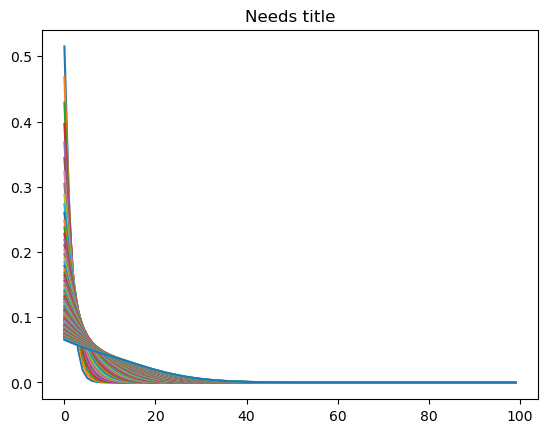

In [15]:
dens = np.empty((Nx,ntaus))
fss = np.empty((nk,ntaus))
for i,mu in enumerate(mus):
    fs = occs(vals,mu,taus[i])
    fss[:,i] = fs
    dens[:,i] = dens_function(fs,vecs,x)
plt.plot(fss)
plt.xlabel('')
plt.ylabel('')
plt.title("Needs title")
plt.show()

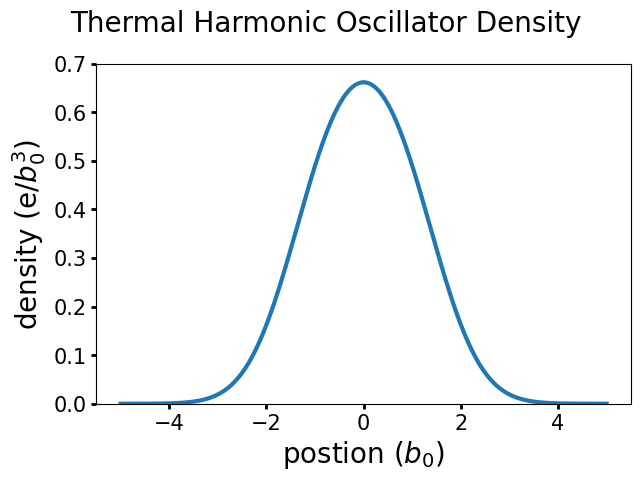

In [16]:
#---------------> Plot
fig, ax = plt.subplots(ncols=1, dpi=100) #sharex=True, sharey=True, dpi=200)
#---------------> Data
ax.plot(x,dens[:,0], linewidth=3,)
#---------------> Formatting
ax.set_ylim(0, 0.7)

#ax.set(adjustable='box', aspect='equal')
ax.set_xlabel('postion ($b_0$)', fontsize=20)
ax.set_ylabel('density (e/$b_0^3$)', fontsize=20)
fig.suptitle("Thermal Harmonic Oscillator Density", fontsize=20)
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

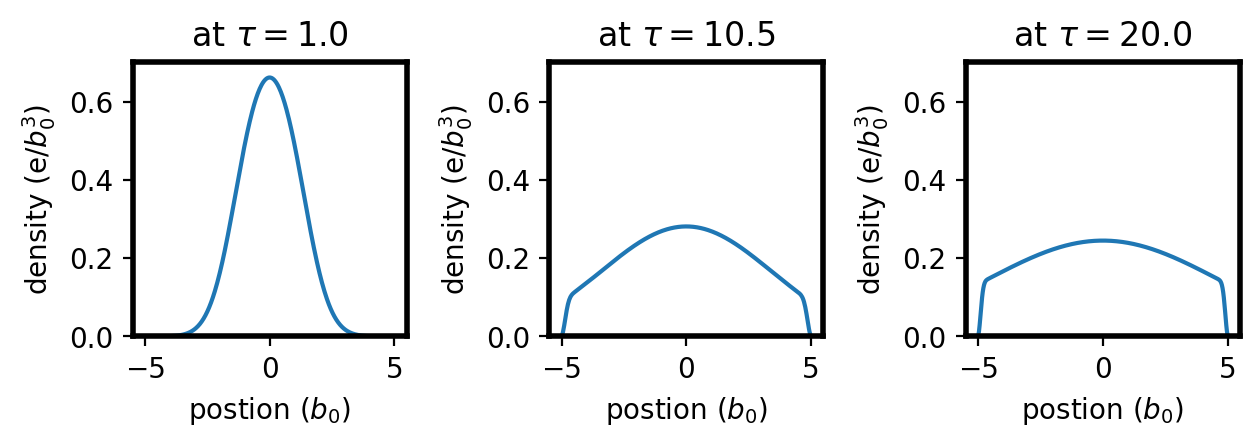

In [17]:
#---------------> Plot
fig, ax = plt.subplots(ncols=3, dpi=200) #sharex=True, sharey=True, dpi=200)
#---------------> Data
ax[0].plot(x,dens[:,0])
ax[1].plot(x,dens[:,50])
ax[2].plot(x,dens[:,100])
#---------------> Formatting
ax[0].set_ylim(0, 0.7)
ax[1].set_ylim(0, 0.7)
ax[2].set_ylim(0, 0.7)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
#ax[0].set(adjustable='box', aspect='equal')
#ax[1].set(adjustable='box', aspect='equal')
#ax[2].set(adjustable='box', aspect='equal')
ax[0].set_xlabel('postion ($b_0$)')
ax[1].set_xlabel('postion ($b_0$)')
ax[2].set_xlabel('postion ($b_0$)')
ax[0].set_ylabel('density (e/$b_0^3$)')
ax[1].set_ylabel('density (e/$b_0^3$)')
ax[2].set_ylabel('density (e/$b_0^3$)')
ax[0].title.set_text('at $\\tau = 1.0 $')
ax[1].title.set_text('at $\\tau = 10.5 $')
ax[2].title.set_text('at $\\tau = 20.0 $')
#fig.suptitle("Thermal Harmonic Oscillator Density")
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
#plt.rcParams["axes.edgecolor"] = "black"
#plt.rcParams["axes.linewidth"] = 1.00


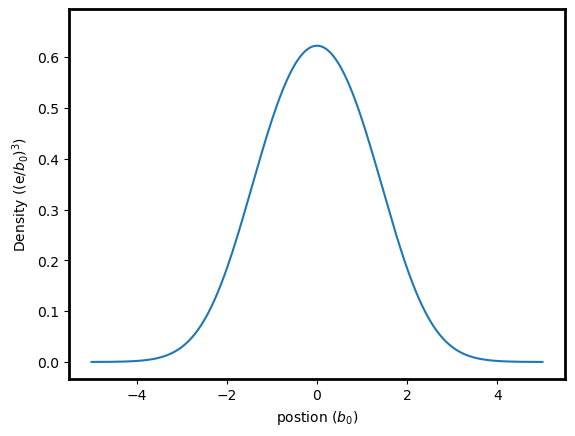

In [18]:
fig, ax = plt.subplots(1,1, dpi=100)
#---------------> Data
line = ax.plot(x,dens[:,0])[0]
#---------------> Formatting
ax.set_xlabel('postion ($b_0$)')
ax.set_ylabel('Density ((e/$b_0)^3$)')
#---------------> Animation
def update(frame):
    line.set_data(x,dens[:,frame+1])
    return line
ani = animation.FuncAnimation(fig=fig, func=update, frames=ntaus-1, interval=30)
writergif = animation.PillowWriter(fps=30)
ani.save('thermal_harmonic_oscillator.gif',writer=writergif)

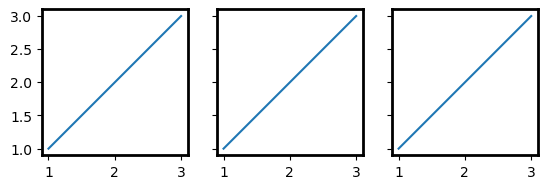

In [19]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)
axes[0].plot([1, 2, 3], [1, 2, 3])
axes[1].plot([1, 2, 3], [1, 2, 3])
axes[2].plot([1, 2, 3], [1, 2, 3])
axes[0].set(adjustable='box', aspect='equal')
axes[1].set(adjustable='box', aspect='equal')
axes[2].set(adjustable='box', aspect='equal')

plt.show()

# Interacting system

## calculate boltzman weights

In [20]:
def boltz_occs(Eis,mu,T,N):
    '''
    INPUT:
        Eis: np.Array, size=(nstates,N)
            The eigenvalues of the zero temprature interacting wavefunctions of the system. It is an nstates x N array.
            Enregy will increase moving down the matrix and number of particlea from left to right. position (0,0)
            will be the ernergy for the ground state of the one particle system.
        Mu: Scalar, float
            The temprature dependent chemical potnetial of the N-particle system.
        T: Scalar, float
            The temprature of the N-particle system in K.
        N: Integer
            The number of particles in the final thermal density.
    OUTPUT:
        w: np.array, size=(nstates,N)
            The boltzamn weights that result in the thermal density at chemical potnetial, mu, and temprature, T.
    '''
    
    kb = 3.166811563e-6 # Ha K^-1
    B = 1/(kb*T)
    nstates = np.shape(Eis)[0]
    
    #calculate the partition function and save the un-normalized boltzman weights. Only have to loop through N one time.
    partition = 0
    w = np.empty((nstates,N))
    for i in range(N):
        for j in range(nstates):
            w[j,i] = np.exp(-B*(Eis[j,i]-(mu*(i+1))))
            partition += w[j,i]
            
    #Normalize the boltzman weights
    w = w/partition
    
    return w, partition

## Generate exact states with the idea code

### To calculate boltzman tempratures I need the density of the system at each number of particles in each k state

In [21]:
def occ_string(N):
    occ_string = ''
    for i in range(N):
        i+=1
        if i%2==0:
            occ_string += 'd'
        else:
            occ_string += 'u'
    return occ_string

def v_atom(Z,x):
    return -Z/(np.abs(x)+.5)

In [22]:
nk = 100
nx = 51
ne = 1

x = np.linspace(-5,5,nx)
vext = v_atom(3,x)
vint = iDEA.interactions.softened_interaction(x)

densities = np.empty((ne,nx,nk))
vals = np.empty((nk,ne))

#for i in range(ne):
for i in [1]:
    print('Ne=', i+1)
    print()
    occ_str = occ_string(i+1)
    s = s = iDEA.system.System(x, vext, vint, electrons=occ_str)
    for k in range(nk):
        print('k=',k)
        state = iDEA.methods.interacting.solve(s, k=k)
        n = iDEA.observables.density(s, state=state)
    
        densities[i-1,:,k] = n
        vals[k,i-1] = state.energy
print('done')

Ne= 2

k= 0
iDEA.methods.interacting.solve: solving eigenproblem...
k= 1
iDEA.methods.interacting.solve: solving eigenproblem...
k= 2
iDEA.methods.interacting.solve: solving eigenproblem...
k= 3
iDEA.methods.interacting.solve: solving eigenproblem...
k= 4
iDEA.methods.interacting.solve: solving eigenproblem...
k= 5
iDEA.methods.interacting.solve: solving eigenproblem...
k= 6
iDEA.methods.interacting.solve: solving eigenproblem...
k= 7
iDEA.methods.interacting.solve: solving eigenproblem...
k= 8
iDEA.methods.interacting.solve: solving eigenproblem...
k= 9
iDEA.methods.interacting.solve: solving eigenproblem...
k= 10
iDEA.methods.interacting.solve: solving eigenproblem...
k= 11
iDEA.methods.interacting.solve: solving eigenproblem...
k= 12
iDEA.methods.interacting.solve: solving eigenproblem...
k= 13
iDEA.methods.interacting.solve: solving eigenproblem...
k= 14
iDEA.methods.interacting.solve: solving eigenproblem...
k= 15
iDEA.methods.interacting.solve: solving eigenproblem...
k= 16
iDEA.

## Plot particle number over $\mu$ at fixed $\tau$ for the interacting system

In [23]:
mus = np.linspace(-50,50,201)
kb = 3.166811563e-6 # Ha K^-1
tau = 1
T = tau/kb
print('temp in K= ',T)
B = 1/(kb*T)
print('coldness= ',B)
Nes = np.empty(len(mus))
Ntar = 2

for mui,mu in enumerate(mus):
    w, partition = boltz_occs(vals,mu,T,ne)
    dens = np.empty(nx)
    for i in range(ne):
        for j in range(nk):
            dens += w[j,i]*densities[i,:,j]
    Nes[mui] = np.trapz(dens,x)- Ntar
print(np.sum(w))

temp in K=  315775.0248494972
coldness=  1.0
0.9999999999999994


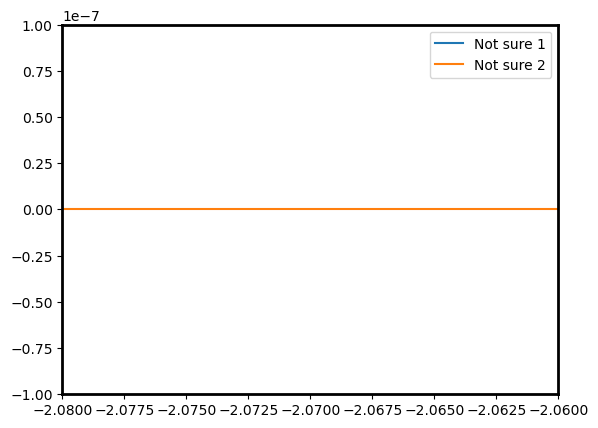

In [24]:
plt.plot(mus,Nes,label="Not sure 1")
plt.plot(mus,np.zeros(len(mus)),label="Not sure 2")
plt.xlim(-2.08,-2.06)
plt.ylim(-.0000001,.0000001)
plt.legend()
plt.show()

In [25]:
w, partition = boltz_occs(vals,-2.0775,T,ne)
dens = np.zeros(nx)
for i in range(ne):
    for j in range(nk):
        dens += w[j,i]*densities[i,:,j]
Ne = np.trapz(dens,x)
print(Ne)

1.9993537717434908


## Use the secant method to find the root for a fixed number of particles, at given temp, $\tau$.

### need a function for calculating the number of particles for given $\mu$, temprature, for a set of eigenvalues and eigenfunctions of the zero temp system.

In [26]:
def boltz_num_func(mu,tau,vals,densities,ne,x):
    '''
    Description: Determine the Unshifted particle number
    INPUT:
        mu: Scalar (float)
            chemical potential
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
    OUTPUT
        Ne: Scalar (float)
            The unshifted particle number
    '''

    nx = len(x)
    nk = vals.shape[0]
    
    # convert temp in units of Ha into K
    kb = 3.166811563e-6 # Ha K^-1
    T = tau/kb

    # obtain boltzman weights 
    w, partition = boltz_occs(vals,mu,T,ne)
    dens = np.zeros(nx)
    for i in range(ne):
        for j in range(nk):
            dens += w[j,i]*densities[i,:,j]
    Ne = np.trapz(dens,x)
    return Ne

def boltz_num_func_func(tau,vals,densities,ne,x,target_ne):
    '''
    Description: Determine the Unshifted particle number
    INPUT:
        mu: Scalar (float)
            chemical potential
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
    OUTPUT
        Ne: Scalar (float)
            The unshifted particle number
    '''

    def boltz_num_func(mu):
        
        nx = len(x)
        nk = vals.shape[0]
    
        # convert temp in units of Ha into K
        kb = 3.166811563e-6 # Ha K^-1
        T = tau/kb

        # obtain boltzman weights 
        w, partition = boltz_occs(vals,mu,T,ne)
        dens = np.zeros(nx)
        for i in range(ne):
            for j in range(nk):
                dens += w[j,i]*densities[i,:,j]
        Ne = np.trapz(dens,x)
        
        return Ne - target_ne
    
    return boltz_num_func

def boltz_dens_function(vals,mu,tau,densities):
    '''
    Description: Determine the Unshifted particle number
    INPUT:
        mu: Scalar (float)
            chemical potential
        tau: Scalar (float)
            Electronic temperature
        vecs: ndarray
            Eigenvectors
        vals: ndarray
            Eigenvalues 
        x: ndarray
            Grid
    OUTPUT
        Ne: Scalar (float)
            The unshifted particle number
    '''
    
    nk = vals.shape[0]
    ne = vals.shape[1]
    nx = len(densities[0,:,0])
    
    kb = 3.166811563e-6 # Ha K^-1
    T = tau/kb
    
    w, partition = boltz_occs(vals,mu,T,ne)

    dens = np.zeros(nx)
    for i in range(ne):
        for j in range(nk):
            dens += w[j,i]*densities[i,:,j]
    return dens

### Use my Secant method with the particle number functions to find the correct chemical potentials

In [27]:
ntaus = 100
taus = np.linspace(1,10,ntaus)
print(taus)
dtau = taus[1]-taus[0]
mus = np.empty(len(taus))
Nes = np.empty(len(taus))

mu0 = 0
mu1 = -5

for i,tau in enumerate(taus):
    
    func = boltz_num_func_func(tau,vals,densities,3,x,2)
    mu1,fx0 = secant_method(mu0,mu1,func,criterion=1e-10)
    
    mus[i] = mu1
    Nes[i] = boltz_num_func(mu1,tau,vals,densities,3,x)
    
    mu0 = mu1-(dtau+(.1*dtau*i))
print(mus)
print(Nes)

[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090909  8.18181818  8.27272727  8.36363636  8.45454545  8.545

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
test_T = 100/kb
w, partition = boltz_occs(vals,-1.55981738,test_T,ne)
plt.imshow(w)
plt.colorbar()
plt.show()
dens = np.zeros(nx)
for i in range(ne):
    for j in range(nk):
        dens += w[j,i]*densities[i,:,j]
plt.plot(x,dens)
plt.ylim(-.1,1.8)
Ne = np.trapz(dens,x)
print(Ne)    

### take the solved $\mu$ and calculate the density at each $\tau$ and animate

In [ ]:
dens = np.empty((nx,ntaus))
for mui,mu in enumerate(mus):
    dens[:,mui] = boltz_dens_function(vals,mu,taus[mui],densities)

fig, ax = plt.subplots()

line = ax.plot(x,dens[:,0])[0]

def update(frame):
    line.set_data(x,dens[:,frame+1])
    return line

ani = animation.FuncAnimation(fig=fig, func=update, frames=ntaus-1, interval=30)
writergif = animation.PillowWriter(fps=30)
ani.save('thermal_interacting_atom.gif',writer=writergif)

In [ ]:
ws = np.empty((ntaus,nk,ne))
for mui,mu in enumerate(mus):
    ws[mui,:,:],_ = boltz_occs(vals,mu,taus[mui]/kb,ne)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
nks = np.arange(nk)
nes = np.arange(ne)
X, Y = np.meshgrid(nks, nes)

# Plot the surface.
surf = ax.plot_surface(X, Y, ws[0,:,:].T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

def update(frame):
    surf.set_data(ws[frame+1,:,:].T)
    return line

def update(frame):
    ax.collections.clear()
    plot = ax.plot_surface(X, Y, ws[frame+1,:,:].T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ani = animation.FuncAnimation(fig=fig, func=update, frames=ntaus-1, interval=30)
writergif = animation.PillowWriter(fps=30)
ani.save('thermal_interacting_atomic_weights.gif',writer=writergif)

# Thermal occupation with pre generated data

In [ ]:
Nes = np.loadtxt('excited_Nes.txt')
Ks = np.loadtxt('excited_Ks.txt')

ne = len(Nes)
nk = len(Ks)
nx = 101

x = np.linspace(-5,5,101)

data = np.load('single_well_123_k1to100.npy',allow_pickle=True).item()

densities = np.empty((ne,nx,nk))
vals = np.empty((nk,ne))

for i,Ne in enumerate(Nes):
    
    if Ne == 1:
        for j,k in enumerate(Ks):
            densities[i,:,j] = data[Ne][k]['density'][0::4]
            vals[j,i] = data[Ne][k]['energy']
    elif Ne == 2:
        for j,k in enumerate(Ks):
            densities[i,:,j] = data[Ne][k]['density'][0::2]
            vals[j,i] = data[Ne][k]['energy']
    else:
        for j,k in enumerate(Ks):
            densities[i,:,j] = data[Ne][k]['density']
            vals[j,i] = data[Ne][k]['energy']

In [ ]:
ntaus = 100
taus = np.linspace(.1,4,ntaus)
print(taus)
dtau = taus[1]-taus[0]
mus = np.empty(len(taus))
Nes = np.empty(len(taus))

mu0 = 0
mu1 = -5

maximum_electron_state = 3
target_num_electrons = 2

for i,tau in enumerate(taus):
    
    func = boltz_num_func_func(tau,vals,densities,maximum_electron_state,x,target_num_electrons)
    mu1,fx0 = secant_method(mu0,mu1,func,criterion=1e-10)
    
    mus[i] = mu1
    Nes[i] = boltz_num_func(mu1,tau,vals,densities,3,x)
    
    mu0 = mu1-(dtau+(.1*dtau*i))
print(mus)
print(Nes)

ws = np.empty((ntaus,nk,ne))
kb = 3.166811563e-6 # Ha K^-1
for mui,mu in enumerate(mus):
    ws[mui,:,:],_ = boltz_occs(vals,mu,taus[mui]/kb,ne)
tp = np.sum(ws[1,:,:],axis=1)
print(tp)
print(np.sum(tp[1:]))

for mui,mu in enumerate(mus):
    tp = np.sum(ws[mui,:,:],axis=1)
    if tp[99] > 1e-3:
        print(mui)
    plt.plot(tp)
plt.show()

In [ ]:
dens = np.empty((nx,ntaus))
for mui,mu in enumerate(mus):
    dens[:,mui] = boltz_dens_function(vals,mu,taus[mui],densities)

plt.plot(dens)
plt.show()

fig, ax = plt.subplots()

line = ax.plot(x,dens[:,0])[0]

def update(frame):
    line.set_data(x,dens[:,frame+1])
    return line

np.save('soft_coulomb_well_and_interaction_dens.npy',dens)

ani = animation.FuncAnimation(fig=fig, func=update, frames=ntaus-1, interval=30)
writergif = animation.PillowWriter(fps=30)
ani.save('thermal_interacting_atom.gif',writer=writergif)

In [ ]:
ws = np.empty((ntaus,nk,ne))
kb = 3.166811563e-6 # Ha K^-1
for mui,mu in enumerate(mus):
    ws[mui,:,:],_ = boltz_occs(vals,mu,taus[mui]/kb,ne)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
nks = np.arange(nk)
nes = np.arange(ne)
X, Y = np.meshgrid(nks, nes)

# Plot the surface.
surf = ax.plot_surface(X, Y, ws[99,:,:].T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
test = np.zeros(len(densities[0,:,0]))
ws = [1.885e-01,  4.817e-01,  3.298e-01]
for i in range(3):
    test+=ws[i]*densities[i,:,99]
plt.plot(test)
plt.savefig('non-thermal max vec.png')
plt.show()
print(simps(test,x))

In [ ]:
def func_func(target_N,target_sum,x,ns,t):
    def func(ws):
        # form the decay function to push weights to lower energy densities
        decay = np.arange(t)
        decay = 3*np.exp(.25*-decay)
        
        # form density
        test = np.zeros(len(x))
        for j in range(t):
            for i in range(3):
                test += ws[(j+1)*i]*ns[i,:,-(j+1)]
        test = simps(test,x)
        
        # calculate cost of density
            # Number and weight sum
        cost = np.abs(test-target_N)+np.abs(target_sum-np.sum(ws))
            # Posotive values
        for w in ws:
            if w < 0:
                cost += 10
            # lower energy eigenvectors
        #for i,d in enumerate(decay):
        #    cost += np.sum(np.abs(d*ws[i*3:(i+1)*3]))
        return cost
    return func

In [ ]:
t = 1
endt = 100
dens = np.empty((nx,endt))

while t < endt+1:
    print(t)
    #testing weighting of weights
    decay = np.arange(t)
    decay = np.exp(.25*-decay)
    
    # solving weights for densities
    func_to_min = func_func(2,1,x,densities,t)
    weights = np.ones(t*3)*(1/(t*3))
    if t > 1:
        weights[0:3*(t-1)] = temp_w
    ws = scipy.optimize.minimize(func_to_min,weights,method='Powell')
    #print(ws)
    temp_w = ws.x
    
    # plotting densities
    test = np.zeros(len(x))
    for j in range(t):
        for i in range(3):
            test += temp_w[(j+1)*i]*densities[i,:,-(j+1)]
    dens[:,t-1] = test
    #plt.plot(test)
    #plt.show()
    #plt.plot(temp_w)
    #plt.show()
    #plt.plot(decay)
    #plt.show()
    test = simps(test,x)
    print(test)
    print()
    t+=1

fig, ax = plt.subplots()

line = ax.plot(x,dens[:,0])[0]

ax.set(ylim=[-.05,.7])

def update(frame):
    line.set_data(x,dens[:,frame+1])
    return line

ani = animation.FuncAnimation(fig=fig, func=update, frames=endt-1, interval=30)
writergif = animation.PillowWriter(fps=30)
ani.save('thermal_relaxation.gif',writer=writergif)

# Thermal DFT Shennanigans

In [ ]:
def A_x():
    return (3/(4*np.pi))*(3*np.pi**2)**(1/3)

def e_x(n):
    return -A_x()*n**(4/3)

def theta(tau,homo):
    return tau/homo

def R_x(th):
    return (4/3)*((.75+3.04363*th**2-0.092270*th**3+1.70350*th**4)/(1+8.31051*th**2+5.1105*th**4))*np.tanh(1/th)

def LDA_tau(n,tau,homo):
    return e_x(n)*R_x(theta(tau,homo))

In [ ]:
def v_H(n,r):
    Nx = len(x)
    dx = x[1]-x[0]
    vh = np.zeros(Nx)
    for ix,xp in enumerate(x):
        integrand = n/np.sqrt((xp-x)**2+.01)
        vh[ix] = simps(integrand,dx=dx)
    return vh